In [1]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
# set style
sns.set_style("ticks")   #whitegrid

In [3]:
color_dict = {
    'Maria Island': (9/255, 147/255, 150/255),  # RGB values must be in [0, 1] range
    'Jervis Bay': 'goldenrod',
    'Jurien': (188/255, 62/255, 3/255),
    'Kalbarri': (35/255, 0/255, 25/255)
}

### combined figure (sst, inten, dhd, dtdt)

In [6]:
source = '...'

In [7]:
location_key_temps = {
    'location': ['Maria Island', 'Maria Island','Jervis Bay', 'Jervis Bay', 'Jurien', 'Jurien', 'Kalbarri'],
    'key_temp': [16.6, 22.2, 22.6, 23.5], # just sample values
    'color': ['teal', 'teal', 'goldenrod', 'goldenrod', 'brown', 'brown', 'navy'] 
}
location_key_temps = pd.DataFrame(location_key_temps)
location_key_temps

,location,key_temp,zero_inten,color
0,Maria Island,16.6,1.16,teal
1,Maria Island,16.8,0.00,teal
2,Jervis Bay,22.2,0.97,goldenrod
3,Jervis Bay,23.2,0.00,goldenrod
4,Jurien,22.6,1.82,brown
5,Jurien,23.7,0.00,brown
6,Kalbarri,24.0,1.70,navy


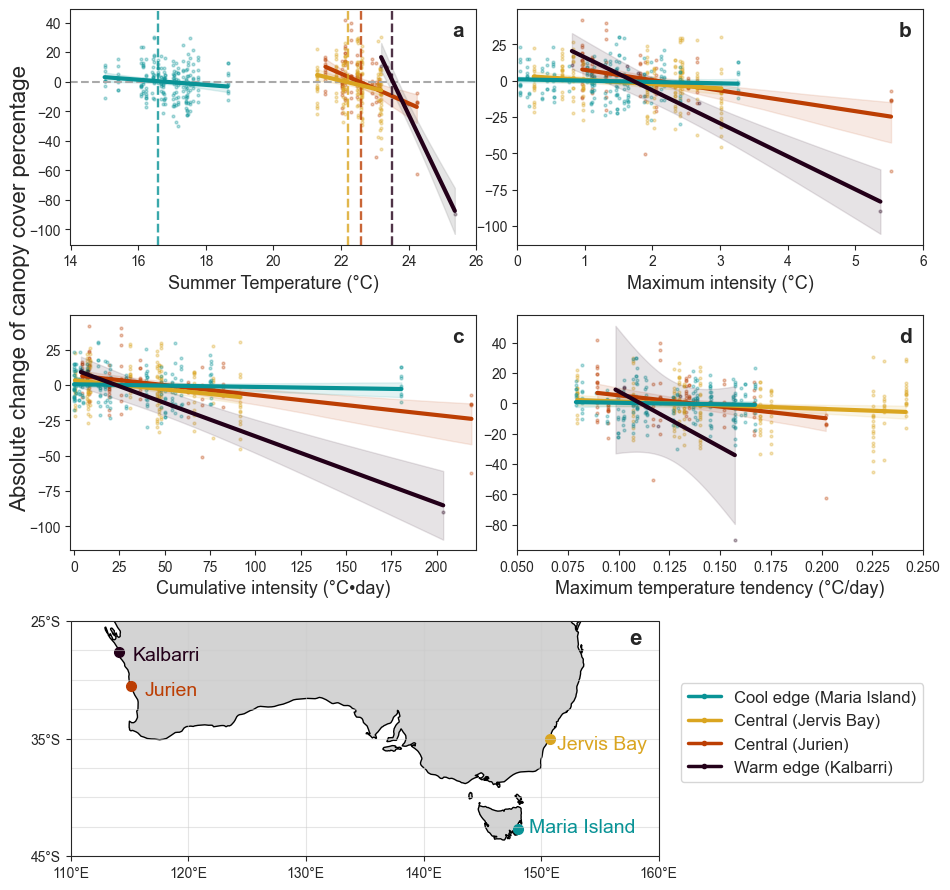

In [13]:
# fig, axs = plt.subplots(3, 2, figsize=(11, 11), gridspec_kw={'height_ratios': [1, 1, 0.8]}, sharex=False)  #   Adjust the figsize as needed,   not sharey=True
fig = plt.figure(figsize=(11,11))

axs[0, 0] = fig.add_subplot(3, 2, 1) 
axs[0, 1] = fig.add_subplot(3, 2, 2) 
axs[1, 0] = fig.add_subplot(3, 2, 3) 
axs[1, 1] = fig.add_subplot(3, 2, 4) 

df_observed = pd.read_csv('4pop_change_rawdata.csv')
for i in df_observed.location.unique():
    df_ob_i = df_observed[df_observed.location == i]
    axs[0, 0].scatter(df_ob_i.summer_temp_max, df_ob_i.survey_change, s = 4, label=i, color=color_dict[i], alpha = 0.3) 
    axs[0, 1].scatter(df_ob_i.summer_inten_max, df_ob_i.survey_change, s = 4, label=i, color=color_dict[i], alpha = 0.3) 
    axs[1, 0].scatter(df_ob_i.summer_dhd50_max, df_ob_i.survey_change, s = 4, label=i, color=color_dict[i], alpha = 0.3)
    axs[1, 1].scatter(df_ob_i.summer_dtdt_max, df_ob_i.survey_change, s = 4, label=i, color=color_dict[i], alpha = 0.3)

# ================  modelled data ==============================================================================
df_model = pd.read_csv('model_change_relationship.csv')
df_kalbarri = pd.read_csv('model_change_sst_kalbarri.csv')

axs[0, 0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
for i in df_model.location.unique():
    df_model_i = df_model[df_model.location == i]
    
    axs[0, 0].axvline(x = location_key_temps.key_temp[location_key_temps.location == i].iloc[0], color = color_dict[i], 
                linestyle='--', linewidth=1.7, alpha=0.8)

    axs[0, 0].plot(df_model_i.summer_temp_max, df_model_i.predicted_change, linestyle='-', linewidth=3, label=i, color=color_dict[i])  # Use the color from the dictionary
    axs[0, 0].fill_between(df_model_i.summer_temp_max, df_model_i.lower_bound, df_model_i.upper_bound, color=color_dict[i], alpha=0.13)  # gray fill between bounds for the confidence interval


## Kalbarri===================================================================================================
axs[0, 0].axvline(x = 23.5, color = (35/255, 0/255, 25/255), linestyle='--', linewidth=1.7, alpha=0.8)
axs[0, 0].plot(df_kalbarri.summer_temp_max, df_kalbarri.predicted_change, linestyle='-', linewidth=3, label='Kalbarri', color=(35/255, 0/255, 25/255))  # Use the color from the dictionary
axs[0, 0].fill_between(df_kalbarri.summer_temp_max, df_kalbarri.lower_bound, df_kalbarri.upper_bound, color='gray', alpha=0.2)  # gray fill between bounds for the confidence interval

axs[0, 0].set_xlabel(u'Summer Temperature (\u00B0C)', fontsize=13)
# axs[0, 0].set_ylim(-32, 25)
axs[0, 0].set_xlim(14, 26)

# ========================================== max intensity =========================================================
df_model = pd.read_csv('inten_max_model_change_relationship.csv')
for i in df_model.location.unique():
    df_model_i = df_model[df_model.location == i]
    # axs[0, 1].axvline(x = location_key_temps.zero_inten[location_key_temps.location == i].iloc[0], color = color_dict[i], 
    #             linestyle='--', linewidth=2, alpha=0.8)
    axs[0, 1].plot(df_model_i.summer_inten_max, df_model_i.predicted_change, linestyle='-', linewidth=3, label=i, color=color_dict[i])  # Use the color from the dictionary
    axs[0, 1].fill_between(df_model_i.summer_inten_max, df_model_i.lower_bound, df_model_i.upper_bound, color=color_dict[i], alpha=0.11)  # gray fill between bounds for the confidence interval

axs[0, 1].set_xlabel(u'Maximum intensity (\u00B0C)', fontsize=13)
axs[0, 1].set_xlim(0, 6)
# axs[0, 1].set_ylim(-47, 27)

# ========================================== dhd ===================================================================
df_model = pd.read_csv('dhdmodel_change_relationship.csv')
for i in df_model.location.unique():
    df_model_i = df_model[df_model.location == i]

    axs[1, 0].plot(df_model_i.summer_dhd50_max, df_model_i.predicted_change, linestyle='-', linewidth=3, label=i, color=color_dict[i])  # Use the color from the dictionary
    axs[1, 0].fill_between(df_model_i.summer_dhd50_max, df_model_i.lower_bound, df_model_i.upper_bound, color=color_dict[i], alpha=0.11)  # gray fill between bounds for the confidence interval

axs[1, 0].set_xlabel(u'Cumulative intensity (\u00B0C•day)', fontsize=13)
axs[1, 0].set_xlim(-2, 222)
# axs[1, 0].set_ylim(-52, 12)

# ========================================= max temperature tendency ===============================================
df_model = pd.read_csv('dtdtmodel_change_relationship.csv')
for i in df_model.location.unique():
    df_model_i = df_model[df_model.location == i]

    axs[1, 1].plot(df_model_i.summer_dtdt_max, df_model_i.predicted_change, linestyle='-', linewidth=3, label=i, color=color_dict[i])  # Use the color from the dictionary
    axs[1, 1].fill_between(df_model_i.summer_dtdt_max, df_model_i.lower_bound, df_model_i.upper_bound, color=color_dict[i], alpha=0.11)  # gray fill between bounds for the confidence interval

axs[1, 1].set_xlabel(u'Maximum temperature tendency (\u00B0C/day)', fontsize=13)  # u'Maximum temperature tendency (\u00B0C•$\mathregular{day^{-1}}$)'
axs[1, 1].set_xlim(0.05, 0.25)
# axs[1, 1].set_ylim(-27, 22)

# Adding 'a', 'b', 'c', 'd' to each subplot
axs[0, 0].text(0.94, 0.95, 'a', transform=axs[0, 0].transAxes, fontsize=15, fontweight='bold', va='top')
axs[0, 1].text(0.94, 0.95, 'b', transform=axs[0, 1].transAxes, fontsize=15, fontweight='bold', va='top')
axs[1, 0].text(0.94, 0.95, 'c', transform=axs[1, 0].transAxes, fontsize=15, fontweight='bold', va='top')
axs[1, 1].text(0.94, 0.95, 'd', transform=axs[1, 1].transAxes, fontsize=15, fontweight='bold', va='top')


# ================================
# Add a common y-label
fig.text(0.07, 0.63, 'Absolute change of canopy cover percentage ', va='center', rotation='vertical', fontsize=16) # , weight = 'bold'

plt.subplots_adjust(hspace=0.3, wspace=0.1) 
# =============================================Add the wide plot at the bottom, spanning both columns =============================
axs_wide = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())  # Spanning both columns on the last row

# axs_wide.plot(np.array(lon_erobis), np.array(lat_erobis), marker='o', markersize=5, linestyle='none', color=(144/255, 192/255, 255/255), transform=ccrs.PlateCarree())
axs_wide.plot(115.10, -30.55, marker='o', markersize=7, linestyle='none', color=(188/255, 62/255, 3/255), transform=ccrs.PlateCarree())
axs_wide.plot(150.75, -35.05, marker='o', markersize=7, linestyle='none', color='goldenrod', transform=ccrs.PlateCarree())
axs_wide.plot(148.05, -42.65, marker='o', markersize=7, linestyle='none', color=(9/255, 147/255, 150/255), transform=ccrs.PlateCarree())
axs_wide.plot(114.15, -27.67, marker='o', markersize=7, linestyle='none', color=(35/255, 0/255, 25/255), transform=ccrs.PlateCarree())   ## Kalbarri


axs_wide.coastlines()
axs_wide.gridlines(alpha=0.5)
# ax1.add_feature(cfeature.OCEAN, facecolor='azure')
axs_wide.add_feature(cfeature.LAND, facecolor='lightgrey')

axs_wide.text(118.10, -27.15, 'Kalbarri', fontsize=14, color =(35/255, 0/255, 25/255), verticalalignment='top', horizontalalignment='center', transform=ccrs.PlateCarree())
axs_wide.text(118.50, -30.15, 'Jurien', fontsize=14, color =(188/255, 62/255, 3/255), verticalalignment='top', horizontalalignment='center', transform=ccrs.PlateCarree())
axs_wide.text(155.2, -34.7, 'Jervis Bay', fontsize=14, color ='goldenrod', verticalalignment='top', horizontalalignment='center', transform=ccrs.PlateCarree())
axs_wide.text(153.45, -41.75, 'Maria Island', fontsize=14, color =(9/255, 147/255, 150/255), verticalalignment='top', horizontalalignment='center', transform=ccrs.PlateCarree())
# Set the desired x and y range
lon_range = [110, 160]
lat_range = [-45, -25]
# Set the x and y axis limits
axs_wide.set_xlim(lon_range)
axs_wide.set_ylim(lat_range)
# Define the tick format functions
lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'S' if x < 0 else 'N'))
lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'W' if x < 0 else 'E'))
# Set the x and y tick positions and labels
axs_wide.set_xticks(np.arange(lon_range[0], lon_range[1]+1, 10), crs=ccrs.PlateCarree())
axs_wide.set_xticklabels([lon_formatter(x) for x in axs_wide.get_xticks()], fontsize=10)
axs_wide.set_yticks(np.arange(lat_range[0], lat_range[1]+1, 10), crs=ccrs.PlateCarree())
axs_wide.set_yticklabels([lat_formatter(y) for y in axs_wide.get_yticks()], fontsize=10)


# Move the wide plot slightly down and left to give more space
pos = axs_wide.get_position()
axs_wide.set_position([pos.x0 - 0.12, pos.y0-0.00 , pos.width , pos.height])
axs_wide.text(0.95, 0.97, 'e', transform=axs_wide.transAxes, fontsize=16, fontweight='bold', va='top')

# Correctly create custom legend handles
handles = [
    mlines.Line2D([], [], linewidth=2.5, marker='.', color=(9/255, 147/255, 150/255), label='Cool edge (Maria Island)'),
    mlines.Line2D([], [], linewidth=2.5, marker='.', color='goldenrod', label='Central (Jervis Bay)'),
    mlines.Line2D([], [], linewidth=2.5, marker='.', color=(188/255, 62/255, 3/255), label='Central (Jurien)'),
    mlines.Line2D([], [], linewidth=2.5, marker='.', color=(35/255, 0/255, 25/255), label='Warm edge (Kalbarri)')
]
fig.legend(handles=handles, fontsize=12, loc='lower center', ncol = 1, bbox_to_anchor=(0.79, 0.17))


In [14]:
fig.savefig('...', dpi=300, bbox_inches='tight')

### Compare temperature-change model

In [23]:
df_model = pd.read_csv('model_4pop_change_monthmaxtemp.csv')

df_observed = pd.read_csv('4pop_change_monthmaxtemp_raw.csv')

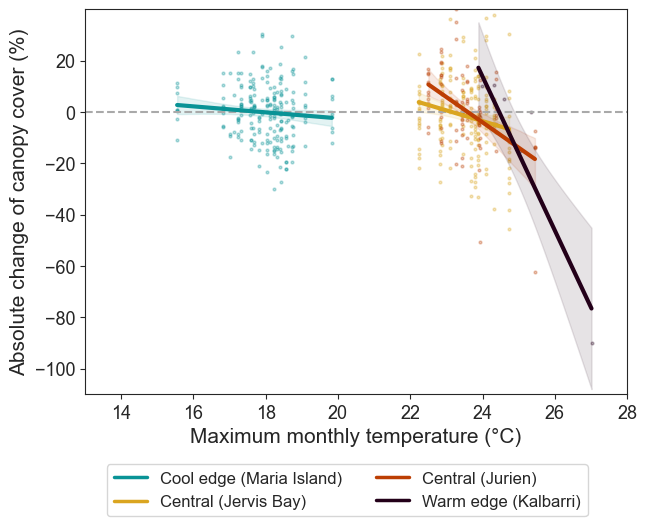

In [26]:
fig = plt.figure(figsize=(7, 5))

for i in df_observed.location.unique():
    df_ob_i = df_observed[df_observed.location == i]
    plt.scatter(df_ob_i.summer_temp_max, df_ob_i.survey_change, s = 4, label=i, color=color_dict[i], alpha = 0.3) 

plt.axhline(y = 0, color = 'darkgrey', linestyle = '--')
for i in df_model.location.unique():
    df_model_i = df_model[df_model.location == i]

    plt.plot(df_model_i.summer_temp_max, df_model_i.predicted_change, linestyle='-', linewidth=3, label=i, color=color_dict[i])  # Use the color from the dictionary
    plt.fill_between(df_model_i.summer_temp_max, df_model_i.lower_bound, df_model_i.upper_bound, color=color_dict[i], alpha=0.11)  # gray fill between bounds for the confidence interval


# plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Absolute change of canopy cover (%)', fontsize=15)
plt.xlabel(u'Maximum monthly temperature (\u00B0C)', fontsize=15)  # Summer temperature

plt.ylim(-110, 40)
plt.xlim(13, 28)
# plt.xticks(np.arange(13, 26, 4))

plt.xticks(fontsize=13)
plt.yticks(np.arange(-100, 40, 20), fontsize=13)
# plt.grid(True, alpha = 0.3)

handles = [
    mlines.Line2D([], [], linewidth=2.5, color=(9/255, 147/255, 150/255), label='Cool edge (Maria Island)'),
    mlines.Line2D([], [], linewidth=2.5, color='goldenrod', label='Central (Jervis Bay)'),
    mlines.Line2D([], [], linewidth=2.5, color=(188/255, 62/255, 3/255), label='Central (Jurien)'),
    mlines.Line2D([], [], linewidth=2.5, color=(35/255, 0/255, 25/255), label='Warm edge (Kalbarri)')
]
fig.legend(handles=handles, fontsize=12, loc='lower center', ncol = 2, bbox_to_anchor=(0.5, -0.15))


In [27]:
fig.savefig('...', dpi=300, bbox_inches='tight')